In [4]:
!pip install geocoder
!pip install folium
print("all Libraries installed")

     |████████████████████████████████| 98 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
all Libraries installed


In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [75]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude
print("Done")

Done


In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '2P1K5RUDH3KWEECWTZVHTYKUCJHZKP1DE4T1PE2S40ODP51F' # changed my Foursquare ID
    CLIENT_SECRET = 'UR0U5SFBYHSG4BL1BRBYNQCX2DVE3LO21BROEFDGFISQEQPQ' # changed Foursquare Secret
    VERSION = '20210215' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
   
    return df
    print("done")

In [7]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '2P1K5RUDH3KWEECWTZVHTYKUCJHZKP1DE4T1PE2S40ODP51F' # changed my Foursquare ID
    CLIENT_SECRET = 'UR0U5SFBYHSG4BL1BRBYNQCX2DVE3LO21BROEFDGFISQEQPQ' # changed Foursquare Secret
    VERSION = '20210215' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data



In [9]:


# get new york data
new_york_data=get_new_york_data()
new_york_data.head()



Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [10]:
new_york_data.shape

(306, 4)

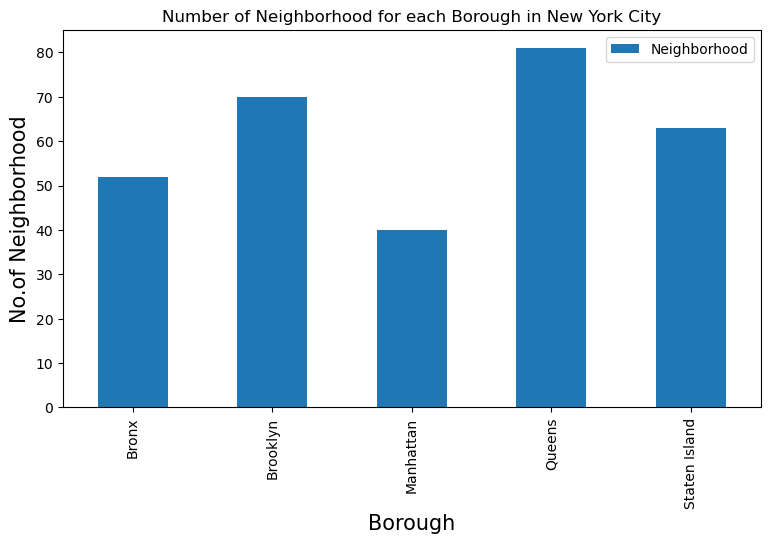

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [12]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [13]:
indian_rest_ny.head()


Borough    Neighborhood                        ID  \
0   Bronx        Woodlawn  4c0448d9310fc9b6bf1dc761   
1   Bronx     Parkchester  4c194631838020a13e78e561   
2   Bronx  Spuyten Duyvil  4c04544df423a593ac83d116   
3   Bronx       Concourse  551b7f75498e86c00a0ed2e1   
4   Bronx       Unionport  4c194631838020a13e78e561   

                          Name  
0                   Curry Spot  
1  Melanies Roti Bar And Grill  
2         Cumin Indian Cuisine  
3                  Hungry Bird  
4  Melanies Roti Bar And Grill

In [15]:
indian_rest_ny.shape

(144, 4)

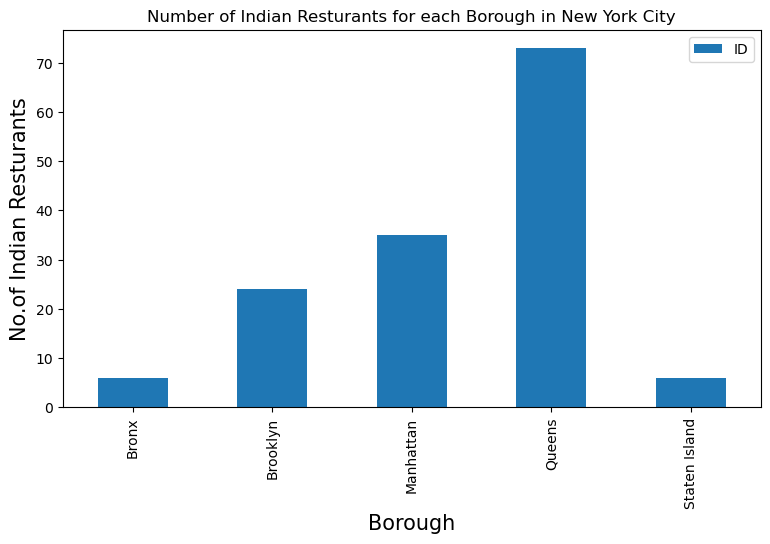

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

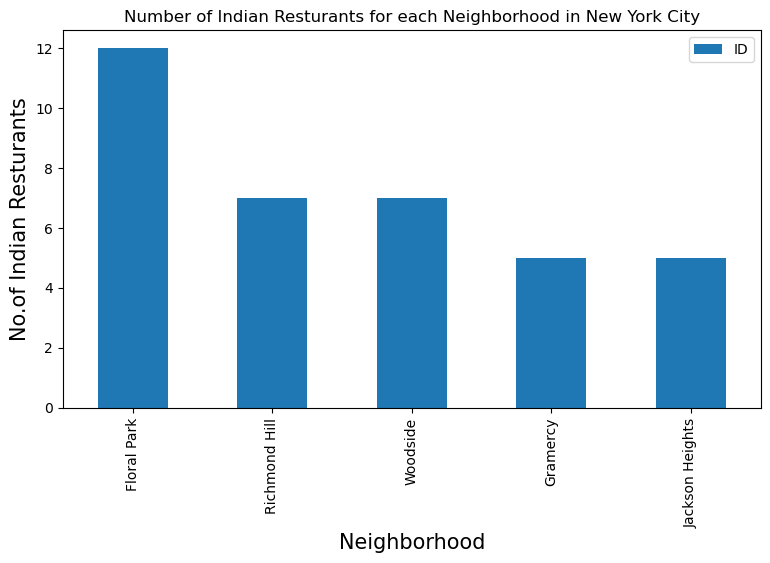

In [17]:


plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()



In [18]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

Borough Neighborhood                        ID  \
102  Queens  Floral Park  4e4e3e22bd4101d0d7a5c2d1   
103  Queens  Floral Park  4b647b56f964a520c4b62ae3   
104  Queens  Floral Park  527ffc0811d2d329d5e49abd   
105  Queens  Floral Park  4b787c49f964a5209cd12ee3   
106  Queens  Floral Park  4c0c01e0bbc676b00d6b4cd5   
107  Queens  Floral Park  4df0f39dd4c04d0392c853ea   
108  Queens  Floral Park  4c76ff35a5676dcb72671721   
109  Queens  Floral Park  4c953a7672dd224bd8d1a191   
110  Queens  Floral Park  55d68c1b498ecf05fa196fe1   
111  Queens  Floral Park  5d06c43cc03635002cc463f2   
112  Queens  Floral Park  4c3e17f2ca012d7f82022fbe   
113  Queens  Floral Park  4e6bfe1c7d8b2c711b17bbe5   

                                Name  
102                   Kerala Kitchen  
103         Usha Foods & Usha Sweets  
104                    Jackson Diner  
105        Santoor Indian Restaurant  
106                    Mumbai Xpress  
107                    Sagar Chinese  
108                  Flavor Of India  
109   Real Usha Sweets & Snacks Inc.  
110      Namaste Restaurant and Cafe  
111                           Honest  
112  Mushin's Halal Food [Gyro Cart]  
113          Surya sweets and snacks

In [19]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.4    10
( 1 / 144 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 2 / 144 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 144 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.1     3
( 4 / 144 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.9     2
( 5 / 144 ) processed
                         ID          Name  Likes  Rating  Tips
0  545835a1498e820edc6f636f  Bombay Grill     14     7.4     4
( 6 / 144 ) processed
                         ID       Name  Li

KeyError: 'venue'

In [20]:
indian_rest_stats_ny.head()

Borough    Neighborhood                        ID  \
0   Bronx        Woodlawn  4c0448d9310fc9b6bf1dc761   
1   Bronx     Parkchester  4c194631838020a13e78e561   
2   Bronx  Spuyten Duyvil  4c04544df423a593ac83d116   
3   Bronx       Concourse  551b7f75498e86c00a0ed2e1   
4   Bronx       Unionport  4c194631838020a13e78e561   

                          Name Likes  Rating Tips  
0                   Curry Spot     5     7.4   10  
1  Melanies Roti Bar And Grill     3     5.9    2  
2         Cumin Indian Cuisine    13     5.9    9  
3                  Hungry Bird     8     7.1    3  
4  Melanies Roti Bar And Grill     3     5.9    2

In [21]:
indian_rest_stats_ny.shape


(50, 7)

In [22]:


indian_rest_ny.shape



(144, 4)

In [23]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [24]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [25]:
indian_rest_stats_ny_csv.shape

(50, 7)

In [26]:
indian_rest_stats_ny_csv.head()

Borough    Neighborhood                        ID  \
0   Bronx        Woodlawn  4c0448d9310fc9b6bf1dc761   
1   Bronx     Parkchester  4c194631838020a13e78e561   
2   Bronx  Spuyten Duyvil  4c04544df423a593ac83d116   
3   Bronx       Concourse  551b7f75498e86c00a0ed2e1   
4   Bronx       Unionport  4c194631838020a13e78e561   

                          Name  Likes  Rating  Tips  
0                   Curry Spot      5     7.4    10  
1  Melanies Roti Bar And Grill      3     5.9     2  
2         Cumin Indian Cuisine     13     5.9     9  
3                  Hungry Bird      8     7.1     3  
4  Melanies Roti Bar And Grill      3     5.9     2

In [27]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [28]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [29]:


indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')



In [30]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [31]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 36, dtype: object

In [32]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                601
Rating                               9.1
Tips                                 151
Name: 40, dtype: object

In [33]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 36, dtype: object

In [34]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']


In [35]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)



Neighborhood  Average Rating
30                    Tribeca             9.1
24           Prospect Heights             8.9
34               West Village             8.8
4                     Chelsea             8.8
14          Greenwich Village             8.8
13                   Gramercy             8.7
25  Prospect Lefferts Gardens             8.7
9                East Village             8.7
19                    Midtown             8.6
32            Upper West Side             8.6

In [62]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [63]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2  Manhattan           8.236
1   Brooklyn           7.810
0      Bronx           6.440

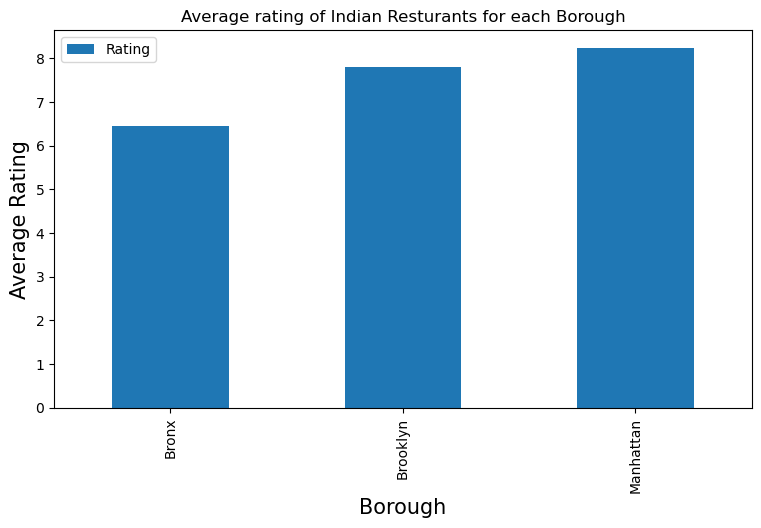

In [64]:


#Similarly these are the average rating of Indian Resturants for each Borough

#Lets visualize it

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [65]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [54]:
#ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [66]:
ny_neighborhood_stats

Neighborhood  Average Rating  Borough_x  Latitude_x  Longitude_x  Borough_y  \
0      Tribeca             9.1  Manhattan   40.721522   -74.010683  Manhattan   

   Latitude_y  Longitude_y  Borough_x  Latitude_x  Longitude_x  Borough_y  \
0   40.721522   -74.010683  Manhattan   40.721522   -74.010683  Manhattan   

   Latitude_y  Longitude_y  
0   40.721522   -74.010683

In [67]:
#We will join this dataset to original new york data to get lonitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [68]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [69]:
ny_neighborhood_stats

Borough Neighborhood   Latitude  Longitude  Average Rating
0  Manhattan      Tribeca  40.721522 -74.010683             9.1

In [76]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [77]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [78]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [79]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

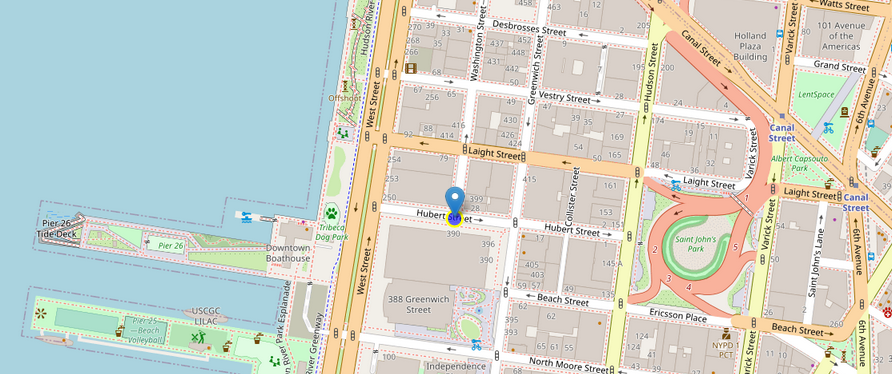

In [82]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'https://raw.githubusercontent.com/ismaan1998/Coursera_Capstone/master/boroughBoundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')
ny_map